In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
files = ['test.csv','train.csv']

In [4]:
dfs = {}
for file in files:
    df = pd.read_csv(file, true_values=['yes','Yes'], false_values=['no','No'])
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = pd.Categorical(df[col])
        elif df[col].dtype == bool:
            df[col] = df[col].astype('int64')
    dfs[file.split('.')[0]] = df

In [5]:
train = dfs['train']

In [6]:
churn_rate = train.groupby('state').agg(total=('churn','count'),
                                        churned=('churn','sum'))

In [7]:
churn_rate['churn_rate'] = churn_rate['churned']/churn_rate['total']

In [8]:
train_dummies = pd.get_dummies(train)

In [9]:
train_dummies = train_dummies.sample(frac=1, random_state=42).reset_index(drop=True)

In [10]:
train_x, test_x, train_y, test_y = train_test_split(train_dummies.drop('churn',axis=1), train_dummies['churn'],
                                                    test_size=0.2, random_state=42, stratify=train_dummies['churn'])

### Trying equal stratified sampling

In [11]:
train_grp = train_dummies.groupby('churn').sample(n=500,random_state=42)

In [12]:
test_grp = train_dummies.drop(train_grp.index)

In [13]:
eq_train_x = train_grp.drop('churn',axis=1)
eq_train_y = train_grp['churn']
eq_test_x = test_grp.drop('churn',axis=1)
eq_test_y = test_grp['churn']

## Using scikit learn

In [14]:
sk_logreg = LogisticRegression()

In [15]:
sk_regr = sk_logreg.fit(X=train_x, y=train_y)

In [16]:
sk_predict_prob_y = sk_regr.predict_proba(test_x)[:,1]

In [17]:
fpr, tpr, thresholds = roc_curve(test_y, sk_predict_prob_y)

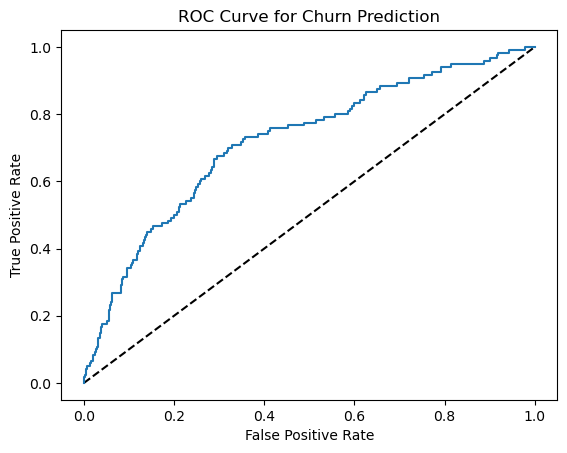

In [18]:
plt.plot([0, 1], [0, 1], 'k--')

# Plot tpr against fpr
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Churn Prediction')
plt.show()

In [19]:
sk_predict_y = sk_regr.predict(test_x)

In [20]:
# Calculate roc_auc_score
print(roc_auc_score(test_y, sk_predict_prob_y))

# Calculate the confusion matrix
print('\n',confusion_matrix(test_y, sk_predict_y))

# Calculate the classification report
print('\n',classification_report(test_y, sk_predict_y))

0.71912100456621

 [[715  15]
 [110  10]]

               precision    recall  f1-score   support

           0       0.87      0.98      0.92       730
           1       0.40      0.08      0.14       120

    accuracy                           0.85       850
   macro avg       0.63      0.53      0.53       850
weighted avg       0.80      0.85      0.81       850



## Using Stats

In [21]:
sm_logreg = sm.Logit(train_y,train_x).fit()

Optimization terminated successfully.
         Current function value: 0.298361
         Iterations 8


In [22]:
sm_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3400
Model:                          Logit   Df Residuals:                     3330
Method:                           MLE   Df Model:                           69
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.2652
Time:                        22:57:17   Log-Likelihood:                -1014.4
converged:                       True   LL-Null:                       -1380.5
Covariance Type:            nonrobust   LLR p-value:                1.715e-111
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
account_length                   -0.0001      0.001     -0.085      0.932      -0.003       0.003
international_plan                2.2155      0.158     14.037      0.000       1.906       2.525
voice_mail_plan                  -2.0522      0.626     -3.276      0.001      -3.280      -0.825
number_vmail_messages             0.0280      0.020      1.418      0.156      -0.011       0.067
total_day_minutes                 4.0117      3.430      1.170      0.242      -2.711      10.734
total_day_calls                   0.0019      0.003      0.662      0.508      -0.004       0.008
total_day_charge                -23.5095     20.175     -1.165      0.244     -63.053      16.033
total_eve_minutes                -0.7001      1.723     -0.406      0.685      -4.077       2.677
total_eve_calls                  -0.0011      0.003     -0.379      0.705      -0.007       0.005
total_eve_charge                  8.3077     20.272      0.410      0.682     -31.424      48.040
total_night_minutes               0.2948      0.916      0.322      0.748      -1.501       2.091
total_night_calls                -0.0030      0.003     -1.029      0.304      -0.009       0.003
total_night_charge               -6.4582     20.359     -0.317      0.751     -46.362      33.445
total_intl_minutes               -2.5757      5.519     -0.467      0.641     -13.393       8.242
total_intl_calls                 -0.0373      0.025     -1.517      0.129      -0.085       0.011
total_intl_charge                 9.9026     20.442      0.484      0.628     -30.163      49.968
number_customer_service_calls     0.5799      0.042     13.883      0.000       0.498       0.662
state_AK                         -1.2973   1.25e+07  -1.04e-07      1.000   -2.45e+07    2.45e+07
state_AL                         -0.5109   1.25e+07  -4.08e-08      1.000   -2.45e+07    2.45e+07
state_AR                         -0.3394   1.25e+07  -2.71e-08      1.000   -2.45e+07    2.45e+07
state_AZ                         -0.7487   1.25e+07  -5.98e-08      1.000   -2.45e+07    2.45e+07
state_CA                          0.7818   1.25e+07   6.25e-08      1.000   -2.45e+07    2.45e+07
state_CO                         -0.6825   1.25e+07  -5.45e-08      1.000   -2.45e+07    2.45e+07
state_CT                         -0.2843   1.25e+07  -2.27e-08      1.000   -2.45e+07    2.45e+07
state_DC                         -0.4580   1.25e+07  -3.66e-08      1.000   -2.45e+07    2.45e+07
state_DE                         -0.4213   1.25e+07  -3.37e-08      1.000   -2.45e+07    2.45e+07
state_FL                         -1.1157   1.25e+07  -8.91e-08      1.000   -2.45e+07    2.45e+07
state_GA                         -0.7312   1.25e+07  -5.84e-08      1.000   -2.45e+07    2.45e+07
state_HI                         -1.6823   1.25e+07  -1.34e-07      1.000   -2.45e+07    2.45e+07
state_IA                         -0.7127   1.25e+07  -5.69e-08      1.000   -2.45e+07    2.45e+07
state_I

In [23]:
sm_prob_y = sm_logreg.predict(test_x)

In [24]:
sm_predict_y = round(sm_prob_y)

In [25]:
# Calculate roc_auc_score
print(accuracy_score(test_y, sm_predict_y))

# Calculate the confusion matrix
print('\n',confusion_matrix(test_y,sm_predict_y))

# Calculate the classification report
print('\n',classification_report(test_y,sm_predict_y))

0.8682352941176471

 [[701  29]
 [ 83  37]]

               precision    recall  f1-score   support

           0       0.89      0.96      0.93       730
           1       0.56      0.31      0.40       120

    accuracy                           0.87       850
   macro avg       0.73      0.63      0.66       850
weighted avg       0.85      0.87      0.85       850



### Model without features with P value ==1

In [26]:
features = train.drop(['state','area_code'],axis=1)

In [27]:
ft_train_x, ft_test_x, ft_train_y, ft_test_y = train_test_split(features.drop('churn',axis=1), features['churn'],
                                                    test_size=0.2, random_state=42, stratify=features['churn'])

In [28]:
ft_logreg = sm.Logit(ft_train_y,ft_train_x).fit()

Optimization terminated successfully.
         Current function value: 0.328302
         Iterations 8


In [29]:
ft_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3400
Model:                          Logit   Df Residuals:                     3383
Method:                           MLE   Df Model:                           16
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1914
Time:                        22:57:17   Log-Likelihood:                -1116.2
converged:                       True   LL-Null:                       -1380.5
Covariance Type:            nonrobust   LLR p-value:                3.089e-102
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
account_length                   -0.0028      0.001     -2.041      0.041      -0.005      -0.000
international_plan                2.1670      0.148     14.688      0.000       1.878       2.456
voice_mail_plan                  -2.4273      0.600     -4.044      0.000      -3.604      -1.251
number_vmail_messages             0.0450      0.019      2.410      0.016       0.008       0.082
total_day_minutes                 7.1399      3.225      2.214      0.027       0.820      13.460
total_day_calls                  -0.0141      0.003     -5.640      0.000      -0.019      -0.009
total_day_charge                -41.9402     18.968     -2.211      0.027     -79.118      -4.763
total_eve_minutes                -1.0324      1.605     -0.643      0.520      -4.178       2.113
total_eve_calls                  -0.0145      0.003     -5.717      0.000      -0.019      -0.009
total_eve_charge                 12.1691     18.880      0.645      0.519     -24.835      49.173
total_night_minutes               0.4778      0.855      0.559      0.576      -1.199       2.154
total_night_calls                -0.0153      0.003     -6.064      0.000      -0.020      -0.010
total_night_charge              -10.6260     19.008     -0.559      0.576     -47.881      26.629
total_intl_minutes                2.1738      5.179      0.420      0.675      -7.978      12.325
total_intl_calls                 -0.0819      0.024     -3.431      0.001      -0.129      -0.035
total_intl_charge                -8.0496     19.183     -0.420      0.675     -45.647      29.548
number_customer_service_calls     0.4754      0.039     12.327      0.000       0.400       0.551
=================================================================================================
"""

In [30]:
ft_prob_y = ft_logreg.predict(ft_test_x)

In [31]:
ft_predict_y = [1 if y>= 0.35 else 0 for y in ft_prob_y]

In [32]:
# Calculate roc_auc_score
print(accuracy_score(ft_test_y, ft_predict_y))

# Calculate the confusion matrix
print('\n',confusion_matrix(ft_test_y,ft_predict_y))

# Calculate the classification report
print('\n',classification_report(ft_test_y,ft_predict_y))

0.8294117647058824

 [[666  64]
 [ 81  39]]

               precision    recall  f1-score   support

           0       0.89      0.91      0.90       730
           1       0.38      0.33      0.35       120

    accuracy                           0.83       850
   macro avg       0.64      0.62      0.63       850
weighted avg       0.82      0.83      0.82       850



In [33]:
tn, fp, fn, tp = confusion_matrix(ft_test_y, ft_predict_y).ravel()

In [34]:
accuracy = (tn+tp)/len(ft_predict_y)
accuracy

0.8294117647058824

In [35]:
precision_0 = tn/(fn+tn)
precision_1 = fp/(fp+tp)

In [36]:
recall_0 = tn/(tn+fp)
recall_1 = tp/(fn+tp)

To reduce false negatives, we want lower precision and higher recall
To reduce false positives, we want higher precision and lower recall

### Reduce Pr threshold of statsmodel with all features

In [37]:
y_pred_lower = [1 if y >=0.35 else 0 for y in sm_prob_y]

In [38]:
# Calculate roc_auc_score
print(accuracy_score(test_y, y_pred_lower))

# Calculate the confusion matrix
print('\n',confusion_matrix(test_y,y_pred_lower))

# Calculate the classification report
print('\n',classification_report(test_y,y_pred_lower))

0.86

 [[675  55]
 [ 64  56]]

               precision    recall  f1-score   support

           0       0.91      0.92      0.92       730
           1       0.50      0.47      0.48       120

    accuracy                           0.86       850
   macro avg       0.71      0.70      0.70       850
weighted avg       0.86      0.86      0.86       850



### Smaller model

In [39]:
small_sm_logreg = sm.Logit(train_y,train_x.iloc[:,:4]).fit()

Optimization terminated successfully.
         Current function value: 0.400603
         Iterations 7


In [40]:
small_sm_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3400
Model:                          Logit   Df Residuals:                     3396
Method:                           MLE   Df Model:                            3
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                 0.01337
Time:                        22:57:17   Log-Likelihood:                -1362.0
converged:                       True   LL-Null:                       -1380.5
Covariance Type:            nonrobust   LLR p-value:                 4.821e-08
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
account_length           -0.0167      0.001    -28.319      0.000      -0.018      -0.016
international_plan        1.6616      0.137     12.154      0.000       1.394       1.930
voice_mail_plan          -2.0127      0.552     -3.646      0.000      -3.095      -0.931
number_vmail_messages     0.0239      0.017      1.365      0.172      -0.010       0.058
=========================================================================================
"""

In [41]:
small_y_pred = round(small_sm_logreg.predict(test_x.iloc[:,:4]))

In [42]:
# Calculate roc_auc_score
print(accuracy_score(test_y, small_y_pred))

# Calculate the confusion matrix
print('\n',confusion_matrix(test_y,small_y_pred))

# Calculate the classification report
print('\n',classification_report(test_y,small_y_pred))

0.8505882352941176

 [[716  14]
 [113   7]]

               precision    recall  f1-score   support

           0       0.86      0.98      0.92       730
           1       0.33      0.06      0.10       120

    accuracy                           0.85       850
   macro avg       0.60      0.52      0.51       850
weighted avg       0.79      0.85      0.80       850



### Model with equal split sample

In [43]:
eq_sm_logreg = sm.Logit(eq_train_y, eq_train_x).fit()

Optimization terminated successfully.
         Current function value: 0.465296
         Iterations 7


In [44]:
eq_sm_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      930
Method:                           MLE   Df Model:                           69
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.3287
Time:                        22:57:17   Log-Likelihood:                -465.30
converged:                       True   LL-Null:                       -693.15
Covariance Type:            nonrobust   LLR p-value:                 2.469e-58
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
account_length                   -0.0018      0.002     -0.826      0.409      -0.006       0.002
international_plan                2.7620      0.280      9.864      0.000       2.213       3.311
voice_mail_plan                  -2.8050      0.861     -3.256      0.001      -4.493      -1.117
number_vmail_messages             0.0570      0.028      2.065      0.039       0.003       0.111
total_day_minutes                 8.0888      5.035      1.607      0.108      -1.779      17.957
total_day_calls                   0.0042      0.004      0.993      0.321      -0.004       0.012
total_day_charge                -47.4908     29.616     -1.604      0.109    -105.537      10.556
total_eve_minutes                 0.7661      2.536      0.302      0.763      -4.204       5.737
total_eve_calls                  -0.0011      0.004     -0.259      0.796      -0.010       0.007
total_eve_charge                 -8.9474     29.836     -0.300      0.764     -67.425      49.530
total_night_minutes               0.6573      1.329      0.495      0.621      -1.948       3.262
total_night_calls                -0.0026      0.004     -0.605      0.545      -0.011       0.006
total_night_charge              -14.4581     29.537     -0.489      0.624     -72.350      43.434
total_intl_minutes                0.9460      7.975      0.119      0.906     -14.684      16.577
total_intl_calls                 -0.0091      0.033     -0.273      0.785      -0.074       0.056
total_intl_charge                -3.1573     29.536     -0.107      0.915     -61.048      54.733
number_customer_service_calls     0.6490      0.061     10.670      0.000       0.530       0.768
state_AK                         -1.2651   8.17e+06  -1.55e-07      1.000    -1.6e+07     1.6e+07
state_AL                         -0.9659   8.17e+06  -1.18e-07      1.000    -1.6e+07     1.6e+07
state_AR                         -0.9685   8.17e+06  -1.18e-07      1.000    -1.6e+07     1.6e+07
state_AZ                         -0.9968   8.17e+06  -1.22e-07      1.000    -1.6e+07     1.6e+07
state_CA                          0.0322   8.17e+06   3.94e-09      1.000    -1.6e+07     1.6e+07
state_CO                         -0.2814   8.17e+06  -3.44e-08      1.000    -1.6e+07     1.6e+07
state_CT                         -0.1668   8.17e+06  -2.04e-08      1.000    -1.6e+07     1.6e+07
state_DC                          0.3270   8.17e+06      4e-08      1.000    -1.6e+07     1.6e+07
state_DE                         -0.0735   8.17e+06  -8.99e-09      1.000    -1.6e+07     1.6e+07
state_FL                          0.7562   8.17e+06   9.25e-08      1.000    -1.6e+07     1.6e+07
state_GA                          0.0666   8.17e+06   8.15e-09      1.000    -1.6e+07     1.6e+07
state_HI                         -2.1811   8.17e+06  -2.67e-07      1.000    -1.6e+07     1.6e+07
state_IA                         -1.1029   8.17e+06  -1.35e-07      1.000    -1.6e+07     1.6e+07
state_I

In [45]:
eq_sm_prob_y = sm_logreg.predict(eq_test_x)

In [46]:
eq_sm_predict_y = round(eq_sm_prob_y)

In [47]:
# Calculate roc_auc_score
print(accuracy_score(eq_test_y, eq_sm_predict_y))

# Calculate the confusion matrix
print('\n',confusion_matrix(eq_test_y,eq_sm_predict_y))

# Calculate the classification report
print('\n',classification_report(eq_test_y,eq_sm_predict_y))

0.9492307692307692

 [[3057   95]
 [  70   28]]

               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3152
           1       0.23      0.29      0.25        98

    accuracy                           0.95      3250
   macro avg       0.60      0.63      0.61      3250
weighted avg       0.95      0.95      0.95      3250



### Model with constant

In [48]:
sm_constant = sm.Logit(train_y, sm.add_constant(train_x)).fit()

Optimization terminated successfully.
         Current function value: 0.298361
         Iterations 9


In [49]:
sm_constant.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  churn   No. Observations:                 3400
Model:                          Logit   Df Residuals:                     3330
Method:                           MLE   Df Model:                           69
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.2652
Time:                        22:57:17   Log-Likelihood:                -1014.4
converged:                       True   LL-Null:                       -1380.5
Covariance Type:            nonrobust   LLR p-value:                1.715e-111
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -6.4110   3.63e+06  -1.77e-06      1.000   -7.11e+06    7.11e+06
account_length                   -0.0001      0.001     -0.085      0.932      -0.003       0.003
international_plan                2.2155      0.158     14.037      0.000       1.906       2.525
voice_mail_plan                  -2.0522      0.626     -3.276      0.001      -3.280      -0.825
number_vmail_messages             0.0280      0.020      1.418      0.156      -0.011       0.067
total_day_minutes                 4.0117      3.430      1.170      0.242      -2.711      10.734
total_day_calls                   0.0019      0.003      0.662      0.508      -0.004       0.008
total_day_charge                -23.5095     20.175     -1.165      0.244     -63.053      16.033
total_eve_minutes                -0.7001      1.723     -0.406      0.685      -4.077       2.677
total_eve_calls                  -0.0011      0.003     -0.379      0.705      -0.007       0.005
total_eve_charge                  8.3077     20.272      0.410      0.682     -31.424      48.040
total_night_minutes               0.2948      0.916      0.322      0.748      -1.501       2.091
total_night_calls                -0.0030      0.003     -1.029      0.304      -0.009       0.003
total_night_charge               -6.4582     20.359     -0.317      0.751     -46.362      33.445
total_intl_minutes               -2.5757      5.519     -0.467      0.641     -13.393       8.242
total_intl_calls                 -0.0373      0.025     -1.517      0.129      -0.085       0.011
total_intl_charge                 9.9026     20.442      0.484      0.628     -30.163      49.968
number_customer_service_calls     0.5799      0.042     13.883      0.000       0.498       0.662
state_AK                         -0.9412   3.02e+06  -3.11e-07      1.000   -5.93e+06    5.93e+06
state_AL                         -0.1547   3.03e+06  -5.11e-08      1.000   -5.94e+06    5.94e+06
state_AR                          0.0167   3.03e+06   5.53e-09      1.000   -5.93e+06    5.93e+06
state_AZ                         -0.3926   3.03e+06   -1.3e-07      1.000   -5.94e+06    5.94e+06
state_CA                          1.1380   3.03e+06   3.76e-07      1.000   -5.93e+06    5.93e+06
state_CO                         -0.3264   3.03e+06  -1.08e-07      1.000   -5.93e+06    5.93e+06
state_CT                          0.0718   3.03e+06   2.37e-08      1.000   -5.93e+06    5.93e+06
state_DC                         -0.1019   3.03e+06  -3.36e-08      1.000   -5.93e+06    5.93e+06
state_DE                         -0.0652   3.03e+06  -2.15e-08      1.000   -5.94e+06    5.94e+06
state_FL                         -0.7595   3.03e+06  -2.51e-07      1.000   -5.93e+06    5.93e+06
state_GA                         -0.3751   3.03e+06  -1.24e-07      1.000   -5.93e+06    5.93e+06
state_HI                         -1.3261   3.03e+06  -4.38e-07      1.000   -5.93e+06    5.93e+06
state_I

### Original Model

In [50]:
sm_predict_y

3384    0.0
1143    0.0
596     0.0
3536    0.0
3435    0.0
       ... 
1985    0.0
2517    0.0
2095    0.0
967     0.0
3789    0.0
Length: 850, dtype: float64

In [51]:
model_summary = pd.read_html(sm_logreg.summary().tables[1].as_html(), header=0, index_col=0)[0]

In [52]:
model_summary

,coef,std err,z,P>|z|,[0.025,0.975]
account_length,-0.0001,1.000000e-03,-8.500000e-02,0.932,-3.000000e-03,3.000000e-03
international_plan,2.2155,1.580000e-01,1.403700e+01,0.000,1.906000e+00,2.525000e+00
voice_mail_plan,-2.0522,6.260000e-01,-3.276000e+00,0.001,-3.280000e+00,-8.250000e-01
number_vmail_messages,0.0280,2.000000e-02,1.418000e+00,0.156,-1.100000e-02,6.700000e-02
total_day_minutes,4.0117,3.430000e+00,1.170000e+00,0.242,-2.711000e+00,1.073400e+01
...,...,...,...,...,...,...
state_WV,-0.1357,1.250000e+07,-1.080000e-08,1.000,-2.450000e+07,2.450000e+07
state_WY,-0.8908,1.250000e+07,-7.120000e-08,1.000,-2.450000e+07,2.450000e+07
area_code_area_code_408,-8.1695,1.250000e+07,-6.530000e-07,1.000,-2.450000e+07,2.450000e+07
area_code_area_code_415,-8.2206,1.250000e+07,-6.570000e-07,1.000,-2.450000e+07,2.450000e+07


## Trial

In [53]:
telco_df = pd.read_csv('wa_telco.csv',true_values=['yes','Yes'], 
                       false_values=['no','No','No phone service','No internet service'])
for col in telco_df.columns:
    if telco_df[col].dtype == 'object':
        telco_df[col] = pd.Categorical(telco_df[col])
    elif telco_df[col].dtype == bool:
        telco_df[col] = telco_df[col].astype('int64')

In [54]:
telco_df.set_index('customerID',inplace=True)

In [55]:
telco_df['TotalCharges'] = telco_df['TotalCharges'].replace(' ',0).astype(float)

In [56]:
telco_dummies = pd.get_dummies(telco_df, drop_first=True)

In [57]:
train_x, test_x, train_y, test_y = train_test_split(telco_dummies.drop('Churn',axis=1), telco_dummies['Churn'],
                                                    test_size=0.2, random_state=42,stratify=telco_dummies['Churn'])

In [63]:
logreg = sm.Logit(train_y, train_x).fit()

Optimization terminated successfully.
         Current function value: 0.412818
         Iterations 8


In [64]:
logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 5634
Model:                          Logit   Df Residuals:                     5611
Method:                           MLE   Df Model:                           22
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.2865
Time:                        22:57:56   Log-Likelihood:                -2325.8
converged:                       True   LL-Null:                       -3259.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================================
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
SeniorCitizen                             0.1474      0.095      1.558      0.119      -0.038       0.333
Partner                                   0.0259      0.087      0.299      0.765      -0.144       0.196
Dependents                               -0.2208      0.101     -2.196      0.028      -0.418      -0.024
tenure                                   -0.0511      0.007     -7.595      0.000      -0.064      -0.038
PhoneService                             -0.4044      0.265     -1.528      0.127      -0.923       0.114
MultipleLines                             0.3170      0.096      3.299      0.001       0.129       0.505
OnlineSecurity                           -0.3873      0.107     -3.613      0.000      -0.597      -0.177
OnlineBackup                             -0.1397      0.099     -1.412      0.158      -0.334       0.054
DeviceProtection                         -0.0050      0.101     -0.050      0.960      -0.202       0.192
TechSupport                              -0.3380      0.108     -3.139      0.002      -0.549      -0.127
StreamingTV                               0.2906      0.125      2.327      0.020       0.046       0.535
StreamingMovies                           0.2908      0.126      2.308      0.021       0.044       0.538
PaperlessBilling                          0.3836      0.083      4.615      0.000       0.221       0.547
MonthlyCharges                           -0.0066      0.007     -0.892      0.372      -0.021       0.008
TotalCharges                              0.0002   7.66e-05      3.047      0.002    8.32e-05       0.000
gender_Male                               0.0283      0.073      0.390      0.697      -0.114       0.171
InternetService_Fiber optic               0.9638      0.225      4.275      0.000       0.522       1.406
InternetService_No                       -0.9715      0.235     -4.130      0.000      -1.432      -0.510
Contract_One year                        -0.7018      0.121     -5.792      0.000      -0.939      -0.464
Contract_Two year                        -1.3725      0.195     -7.040      0.000      -1.755      -0.990
PaymentMethod_Credit card (automatic)    -0.0095      0.128     -0.074      0.941      -0.261       0.242
PaymentMethod_Electronic check            0.4061      0.106      3.843      0.000       0.199       0.613
PaymentMethod_Mailed check                0.1017      0.129      0.791      0.429      -0.150       0.354
=========================================================================================================
"""

In [65]:
y_prob = logreg.predict(test_x)

In [66]:
y_pred = round(y_prob)

In [67]:
# Calculate roc_auc_score
print(accuracy_score(test_y, y_pred))

# Calculate the confusion matrix
print('\n',confusion_matrix(test_y,y_pred))

# Calculate the classification report
print('\n',classification_report(test_y,y_pred))

0.8055358410220014

 [[926 109]
 [165 209]]

               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

